In [1]:
#Load libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.cluster import KMeans
from joblib import dump
import geohash2 as geohash
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from torch.optim.lr_scheduler import LambdaLR

In [2]:
# Load the dataset from csv file
df = pd.read_csv('AmazonDataSales.csv', low_memory=False)

In [3]:
# check for null values
df.isnull().sum()

index                     0
Order ID                  0
Date                      0
Status                    0
Fulfilment                0
Sales Channel             0
ship-service-level        0
Style                     0
SKU                       0
Category                  0
Size                      0
ASIN                      0
Courier Status         6872
Qty                       0
currency               7795
Amount                 7795
ship-city                33
ship-state               33
ship-postal-code         33
ship-country             33
promotion-ids         49153
B2B                       0
fulfilled-by          89698
Unnamed: 22           49050
dtype: int64

In [4]:
# Drop 'promotion-ids', 'fulfilled-by', 'Unnamed: 22' columns
df = df.drop(['promotion-ids', 'fulfilled-by', 'Unnamed: 22', 'currency'], axis=1)

In [5]:
# check columns types
df.dtypes

index                   int64
Order ID               object
Date                   object
Status                 object
Fulfilment             object
Sales Channel          object
ship-service-level     object
Style                  object
SKU                    object
Category               object
Size                   object
ASIN                   object
Courier Status         object
Qty                     int64
Amount                float64
ship-city              object
ship-state             object
ship-postal-code      float64
ship-country           object
B2B                      bool
dtype: object

In [6]:
# Fill in missing 'Courier Status' with "Unknown"
# df['Courier Status'].fillna('Unknown', inplace=True) Seems like inplace=True is being disbanded
df['Courier Status'] = df['Courier Status'].fillna('Unknown')
# Fill missing 'Amount' with mean
df['Amount'] = df['Amount'].fillna(value=df['Amount'].mean() )

Correlation between Qty and Amount: 0.044359066469949894


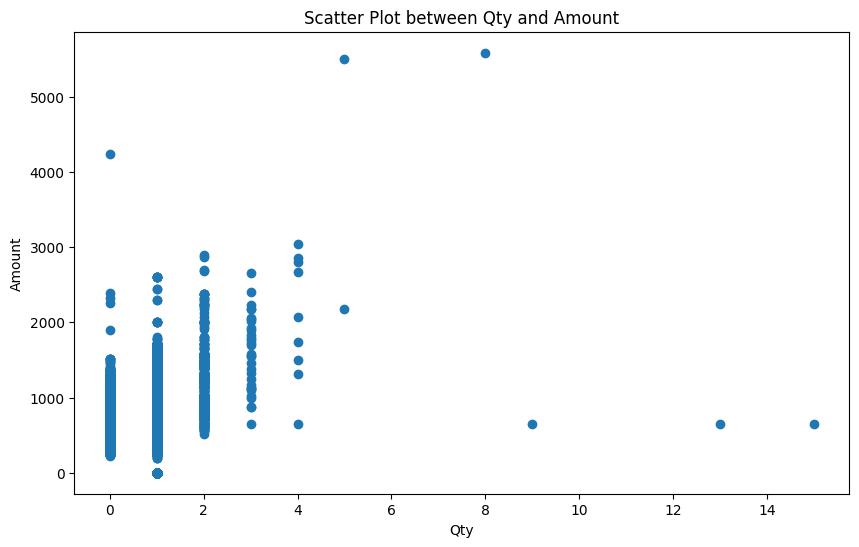

In [7]:
# Explore connection between 'Category', 'Size', 'Qty' in relation to 'Amount'


# Compute the correlation between 'Qty' and 'Amount'
correlation = df['Qty'].corr(df['Amount'])
print("Correlation between Qty and Amount:", correlation)

# Visualize the relationship with a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['Qty'], df['Amount'])
plt.xlabel('Qty')
plt.ylabel('Amount')
plt.title('Scatter Plot between Qty and Amount')
plt.show()

In [8]:
#Explore number of unique values in each column
unique_values = df.nunique()
print(unique_values)

index                 128975
Order ID              120378
Date                      91
Status                    13
Fulfilment                 2
Sales Channel              2
ship-service-level         2
Style                   1377
SKU                     7195
Category                   9
Size                      11
ASIN                    7190
Courier Status             4
Qty                       10
Amount                  1411
ship-city               8955
ship-state                69
ship-postal-code        9459
ship-country               1
B2B                        2
dtype: int64


In [9]:
df['Date'] = pd.to_datetime(df['Date'], format='%m-%d-%y', errors='coerce')

In [10]:
#count null value in columns
df.isnull().sum()

index                  0
Order ID               0
Date                   0
Status                 0
Fulfilment             0
Sales Channel          0
ship-service-level     0
Style                  0
SKU                    0
Category               0
Size                   0
ASIN                   0
Courier Status         0
Qty                    0
Amount                 0
ship-city             33
ship-state            33
ship-postal-code      33
ship-country          33
B2B                    0
dtype: int64

In [11]:
#Drop columns with more than 92 unique values or just one and 'qty' because the weird spread of amount by qty
df = df.drop(['ship-country','index', 'Order ID', 'Style', 'SKU', 'ship-city', 'ship-postal-code', 'ASIN', 'Qty'], axis=1)

In [12]:
#delete rows with missing values
df = df.dropna()

In [13]:
df.columns

Index(['Date', 'Status', 'Fulfilment', 'Sales Channel ', 'ship-service-level',
       'Category', 'Size', 'Courier Status', 'Amount', 'ship-state', 'B2B'],
      dtype='object')

In [14]:
unique_values = df.nunique()
print(unique_values)

Date                    91
Status                  13
Fulfilment               2
Sales Channel            2
ship-service-level       2
Category                 9
Size                    11
Courier Status           4
Amount                1411
ship-state              69
B2B                      2
dtype: int64


In [15]:
#Correct spelling errors in 'ship-state'
# Function to correct and standardize state names
def correct_state_name(state_name):
    corrections = {
        'ARUNACHAL PRADESH': 'Arunachal Pradesh',
        'Arunachal pradesh': 'Arunachal Pradesh',
        'BIHAR': 'Bihar',
        'CHANDIGARH': 'Chandigarh',
        'DELHI': 'Delhi',
        'GOA': 'Goa',
        'GUJARAT': 'Gujarat',
        'HARYANA': 'Haryana',
        'HIMACHAL PRADESH': 'Himachal Pradesh',
        'JAMMU & KASHMIR': 'Jammu & Kashmir',
        'JHARKHAND': 'Jharkhand',
        'KARNATAKA': 'Karnataka',
        'KERALA': 'Kerala',
        'LADAKH': 'Ladakh',
        'LAKSHADWEEP': 'Lakshadweep',
        'MADHYA PRADESH': 'Madhya Pradesh',
        'MAHARASHTRA': 'Maharashtra',
        'MANIPUR': 'Manipur',
        'MEGHALAYA': 'Meghalaya',
        'MIZORAM': 'Mizoram',
        'NAGALAND': 'Nagaland',
        'ODISHA': 'Odisha',
        'PUDUCHERRY': 'Puducherry',
        'PUNJAB': 'Punjab',
        'RAJASTHAN': 'Rajasthan',
        'SIKKIM': 'Sikkim',
        'TAMIL NADU': 'Tamil Nadu',
        'TELANGANA': 'Telangana',
        'TRIPURA': 'Tripura',
        'UTTAR PRADESH': 'Uttar Pradesh',
        'UTTARAKHAND': 'Uttarakhand',
        'WEST BENGAL': 'West Bengal',
        'nan': 'Unknown',
        'Rajshthan': 'Rajasthan',
        'Rajsthan': 'Rajasthan',
        'Orissa': 'Odisha',  # Orissa is the former name of Odisha
        'New Delhi': 'Delhi',  # New Delhi is part of Delhi
        'Pondicherry': 'Puducherry',  # Pondicherry was renamed to Puducherry
        'Punjab/Mohali/Zirakpur': 'Punjab'  # Specific cities in Punjab
    }
    return corrections.get(state_name, state_name.title())

# Apply the corrections to the 'ship-state' column
df['ship-state'] = df['ship-state'].apply(correct_state_name)


In [16]:
#One hot encode all columns with less than 92 unique values except target column 'Amount'
#Make a list of columns except 'Amount'
bool_columns_list = [col for col in df if col != 'Amount']
#One hot encode list of columns
df = pd.get_dummies(df, columns=bool_columns_list)


In [17]:
# Update the list with all the columns now that they have been one-hot encoded
bool_columns_list = [col for col in df if col != 'Amount']

Yolo-Modeling

In [18]:
# Assuming df is your DataFrame and bool_columns is a list of your boolean column names

# Convert boolean columns to float
df[bool_columns_list] = df[bool_columns_list].astype(float)

# Define your features (X) and target (y) from the DataFrame
X = df[bool_columns_list]
y = df['Amount']

# Splitting the dataset into training and test sets (as you've done)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Further split the training set into a new training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Converting to PyTorch tensors and moving to the specified device
device = torch.device('cuda')

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

# Creating datasets and dataloaders for training, validation, and test sets
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_data, batch_size=750, shuffle=True)
val_loader = DataLoader(val_data, batch_size=750, shuffle=False)
test_loader = DataLoader(test_data, batch_size=750, shuffle=False)


In [19]:
device = torch.device("cuda")
print(device)

cuda


In [20]:
class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.6)

        self.fc2 = nn.Linear(100, 80)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)

        # New layers added
        self.fc3 = nn.Linear(80, 60)  # Size roughly halved from previous layer
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.4)

        self.fc4 = nn.Linear(60, 40)  # Size roughly halved from previous layer
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.3)

        self.fc5 = nn.Linear(40, 20)   # Size roughly halved from previous layer
        self.relu5 = nn.ReLU()
        self.dropout5 = nn.Dropout(0.2)

        # Final layer
        self.fc6 = nn.Linear(20, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        # Flow through new layers
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        x = self.relu4(x)
        x = self.dropout4(x)

        x = self.fc5(x)
        x = self.relu5(x)
        x = self.dropout5(x)

        # Final output
        x = self.fc6(x)
        return x


In [21]:
# Initialize the model, loss function, and optimizer
model = RegressionModel(X_train_tensor.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.005, betas=(0.9, 0.999), eps=1e-08)


# Define a lambda function for learning rate decay
def lr_lambda(epoch):
    initial_lr = 0.01
    final_lr = 0.001
    max_epochs = 20000
    decay_rate = (final_lr / initial_lr) ** (1 / max_epochs)
    return decay_rate ** epoch
scheduler = LambdaLR(optimizer, lr_lambda)

In [22]:
# Training the model
# Optimizer: Adam with specified parameters and a learning rate of 0.001

n_epochs = 10000
early_stop_threshold = 0.99
for epoch in range(n_epochs):
    
    model.train()
    train_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)  # Move data to the device
        
        # Clear the gradients of all optimized tensors
        optimizer.zero_grad()
        
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        # Calculate the loss
        loss = criterion(output.view(-1), target)
        
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # Perform a single optimization step (parameter update)
        optimizer.step()
        scheduler.step()
        # Update running training loss
        train_loss += loss.item() * data.size(0)
    
    model.eval()
    with torch.no_grad():
        val_predictions = []
        val_targets = []
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            val_predictions.extend(outputs.view(-1).cpu().numpy())
            val_targets.extend(y.cpu().numpy())
        
        val_r2_score = r2_score(val_targets, val_predictions)
        print(f'Epoch {epoch+1}/{n_epochs}, Validation R2 Score: {val_r2_score}')

        if val_r2_score >= early_stop_threshold:
            print(f"Early stopping at epoch {epoch+1} with R2 Score: {val_r2_score}")
            break

Epoch 1/10000, Validation R2 Score: 0.3830417378241219
Epoch 2/10000, Validation R2 Score: 0.34945896931225273
Epoch 3/10000, Validation R2 Score: 0.3554093011205173
Epoch 4/10000, Validation R2 Score: 0.35851699176525464
Epoch 5/10000, Validation R2 Score: 0.41069079023960486
Epoch 6/10000, Validation R2 Score: 0.3937856600871089
Epoch 7/10000, Validation R2 Score: 0.3794222254171786
Epoch 8/10000, Validation R2 Score: 0.37590793428630065
Epoch 9/10000, Validation R2 Score: 0.3664836712949878
Epoch 10/10000, Validation R2 Score: 0.39954656990010506
Epoch 11/10000, Validation R2 Score: 0.4074567080509085
Epoch 12/10000, Validation R2 Score: 0.41613758075389085
Epoch 13/10000, Validation R2 Score: 0.42180052616958363
Epoch 14/10000, Validation R2 Score: 0.4000541881536296
Epoch 15/10000, Validation R2 Score: 0.41512916410922507
Epoch 16/10000, Validation R2 Score: 0.38510998694979526
Epoch 17/10000, Validation R2 Score: 0.40676407647486645
Epoch 18/10000, Validation R2 Score: 0.41561548

KeyboardInterrupt: 

In [ ]:
# Evaluating the model in detail
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).view(-1)
    
    # Convert tensors to numpy arrays for compatibility with sklearn metrics
    y_test_np = y_test_tensor.cpu().numpy()
    predictions_np = predictions.cpu().numpy()

    # Calculating MAE
    mae = mean_absolute_error(y_test_np, predictions_np)
    print(f'MAE: {mae}')

    # RMSE (already calculated)
    mse = criterion(predictions, y_test_tensor)
    rmse = torch.sqrt(mse)
    print(f'RMSE: {rmse.item()}')

    # R2 Score (already calculated)
    r2 = r2_score(y_test_np, predictions_np)
    print(f'R2 Score: {r2}')

    # Calculating MAPE
    mape = np.mean(np.abs((y_test_np - predictions_np) / y_test_np)) * 100
    print(f'MAPE: {mape}')

    # Adjusted R2 (for multiple regression models)
    n = len(y_test_np) # Number of samples
    p = X_test_tensor.shape[1] # Number of independent variables
    adjusted_r2 = 1 - (1-r2)*(n-1)/(n-p-1)
    print(f'Adjusted R2 Score: {adjusted_r2}')

    print("---------First 10 Predictions---------")
    for actual, predicted in zip(y_test_np[:10], predictions_np[:10]):
        absolute_error = np.abs(actual - predicted)
        relative_error = (absolute_error / actual) * 100 if actual != 0 else float('inf')
        print(f"Actual/Predicted: {actual}/{predicted}")
        print(f"Abs Error: {absolute_error}")
        print(f"Rel Error: {relative_error:.2f}%")

In [ ]:
# save model
#torch.save(model, 'Amazon.pth')